# Loading of pvtu-ASPECT data in yt


This notebook introduces some ways of loading ASPECT output in *yt*. It first describes Manual Loading of pvtu data and then demonstrates usage of a  yt-native ASPECT frontend draft. 


## 1. Manual Loading

Requirements:

* [yt](https://yt-project.org/#getyt)
* [xmltodict](https://pypi.org/project/xmltodict/)
* [meshio](https://pypi.org/project/meshio/) 

### pvtu data

The standard ASPECT vtk output is comprised of unstructured mesh data stored in `.pvtu` files: each `.pvtu` file is a timestep from the ASPECT simulation and each `.pvtu` records the `.vtu` files storing the actual data (when running in parallel, each process will output a `.vtu` file). So in order to load this data into yt manually, we need to parse our `pvtu` files to assemble `connectivity`, `coordinates`and `node_data` arrays and supply them to `load_unstructured_mesh` function: 

```python
import yt 
ds = yt.load_unstructured_mesh(
    connectivity,
    coordinates,
    node_data = node_data
)
```

The following code creates a class to parse a `.pvtu` file and accompanying `.vtu` files using a combination of [xmltodict](https://pypi.org/project/xmltodict/) and [meshio](https://pypi.org/project/meshio/). After instantiating, `pvuFile.load()` will load each `.vtu` file into memory as a separate mesh to give to `load_unstructured_mesh`:

In [25]:
import os, numpy as np
import xmltodict, meshio

class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']     
        
        self.connectivity = None
        self.coordinates = None
        self.node_data = None
            
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 

        con_offset=-1
        pieces = self.pXML['VTKFile']['PUnstructuredGrid']['Piece']
        if not isinstance(pieces,list):
            pieces = [pieces]
            
        for mesh_id,src in enumerate(pieces):    
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.  
            
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
            
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 
        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        cell_type = list(meshPiece.cells_dict.keys())[0]
        
        connectivity=meshPiece.cells_dict[cell_type] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}
        def rshpData(data1d):
            return np.reshape(data1d[con1d],conn_shp)
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=rshpData(point_data[nm][:,component])
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=rshpData(point_data[nm])
    
        return node_data

Now lets set a `.pvtu` solution path then instantiate and load our `pvuFile`:

In [26]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','./'),'output_yt_vtu','solution')
pFile=os.path.join(DataDir,'solution-00000.pvtu')
if os.path.isfile(pFile) is False:
    print("data file not found")
    
pvuData=pvuFile(pFile)
pvuData.load()  

And now let's actually create a *yt* dataset:

In [27]:
import yt 
ds = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data
)

yt : [INFO     ] 2020-11-17 15:28:21,594 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-17 15:28:21,595 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-11-17 15:28:21,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-17 15:28:21,596 Parameters: domain_right_edge         = [110000. 110000. 110000.]
yt : [INFO     ] 2020-11-17 15:28:21,596 Parameters: cosmological_simulation   = 0.0


Now that we have our data loaded as a *yt* dataset, we can do some fun things. First, let's check what fields we have:

In [21]:
ds.field_list

[('all', 'T'),
 ('all', 'crust_lower'),
 ('all', 'crust_upper'),
 ('all', 'current_cohesions'),
 ('all', 'current_friction_angles'),
 ('all', 'density'),
 ('all', 'noninitial_plastic_strain'),
 ('all', 'p'),
 ('all', 'plastic_strain'),
 ('all', 'plastic_yielding'),
 ('all', 'strain_rate'),
 ('all', 'velocity_cx'),
 ('all', 'velocity_cy'),
 ('all', 'velocity_cz'),
 ('all', 'viscosity'),
 ('connect1', 'T'),
 ('connect1', 'crust_lower'),
 ('connect1', 'crust_upper'),
 ('connect1', 'current_cohesions'),
 ('connect1', 'current_friction_angles'),
 ('connect1', 'density'),
 ('connect1', 'noninitial_plastic_strain'),
 ('connect1', 'p'),
 ('connect1', 'plastic_strain'),
 ('connect1', 'plastic_yielding'),
 ('connect1', 'strain_rate'),
 ('connect1', 'velocity_cx'),
 ('connect1', 'velocity_cy'),
 ('connect1', 'velocity_cz'),
 ('connect1', 'viscosity')]

And now let's make a slice plot:

yt : [INFO     ] 2020-11-17 15:25:02,654 xlim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:25:02,655 ylim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:25:02,657 xlim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:25:02,658 ylim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:25:02,659 Making a fixed resolution buffer of (('all', 'T')) 800 by 800



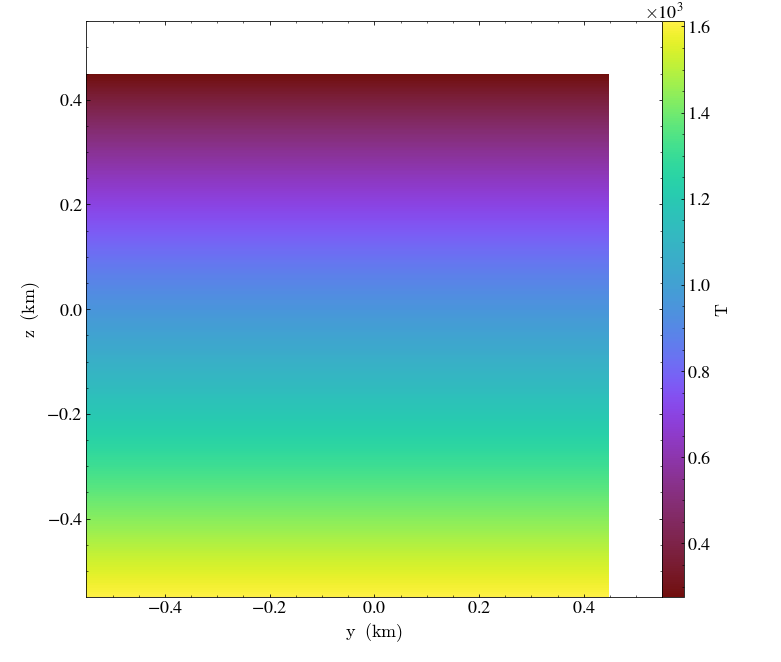

In [24]:
slc = yt.SlicePlot(ds,'x',('all','T'))
slc.set_log('T',False)

yt : [INFO     ] 2020-11-17 15:24:59,365 xlim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:24:59,366 ylim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:24:59,368 xlim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:24:59,369 ylim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-17 15:24:59,371 Making a fixed resolution buffer of (('all', 'strain_rate')) 800 by 800



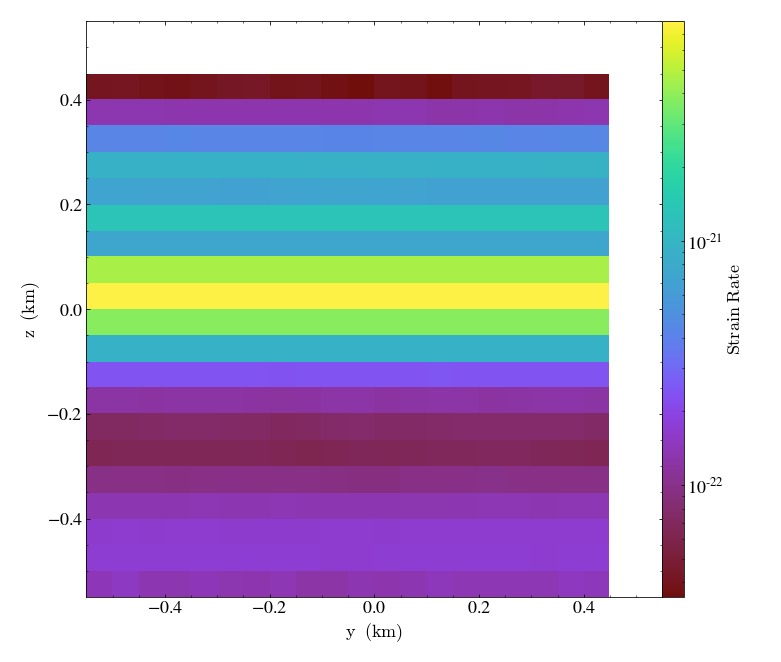

In [23]:
slc = yt.SlicePlot(ds,'x',('all','strain_rate'))
slc.show()

### higher order elements

ASPECT can output higher order hexahedral elements but at present, *yt* only supports plotting first order elements. But *yt* will out the first order nodes of higher order elements, allowing us to plot ASPECT datasets that contain the higher order element data. 

To do this, however, we'll need a modified version of meshio as the current vtu support does not include parsing the higher order elements. so for the following to work, we'll need to use the fork and branch at `https://github.com/chrishavlin/meshio/tree/vtu72` (clone the repository, check out the `vtu72` branch then run `pip install .`). 

In [28]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','../'),'litho_defo_sample','data')
pFile=os.path.join(DataDir,'solution-00002.pvtu')
if os.path.isfile(pFile) is False:
    print("data file not found")
    
pvuData=pvuFile(pFile)
pvuData.load()

and now we see our connectivity arrays have 27 elements:

In [29]:
pvuData.connectivity[0].shape

(581, 27)

and now when we load:

In [30]:
ds_high_order = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data
)

yt : [INFO     ] 2020-11-17 15:37:21,553 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-17 15:37:21,554 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-11-17 15:37:21,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-17 15:37:21,554 Parameters: domain_right_edge         = [88000.   550. 33000.]
yt : [INFO     ] 2020-11-17 15:37:21,555 Parameters: cosmological_simulation   = 0.0


and build a slice:

yt : [INFO     ] 2020-11-17 15:38:49,971 xlim = 0.000000 33000.000000
yt : [INFO     ] 2020-11-17 15:38:49,971 ylim = 0.000000 88000.000000
yt : [INFO     ] 2020-11-17 15:38:49,973 xlim = 0.000000 33000.000000
yt : [INFO     ] 2020-11-17 15:38:49,974 ylim = 0.000000 88000.000000
yt : [INFO     ] 2020-11-17 15:38:49,975 Making a fixed resolution buffer of (('all', 'T')) 800 by 800
yt : [WARNING  ] 2020-11-17 15:38:49,984 High order elements not yet supported, dropping to 1st order.



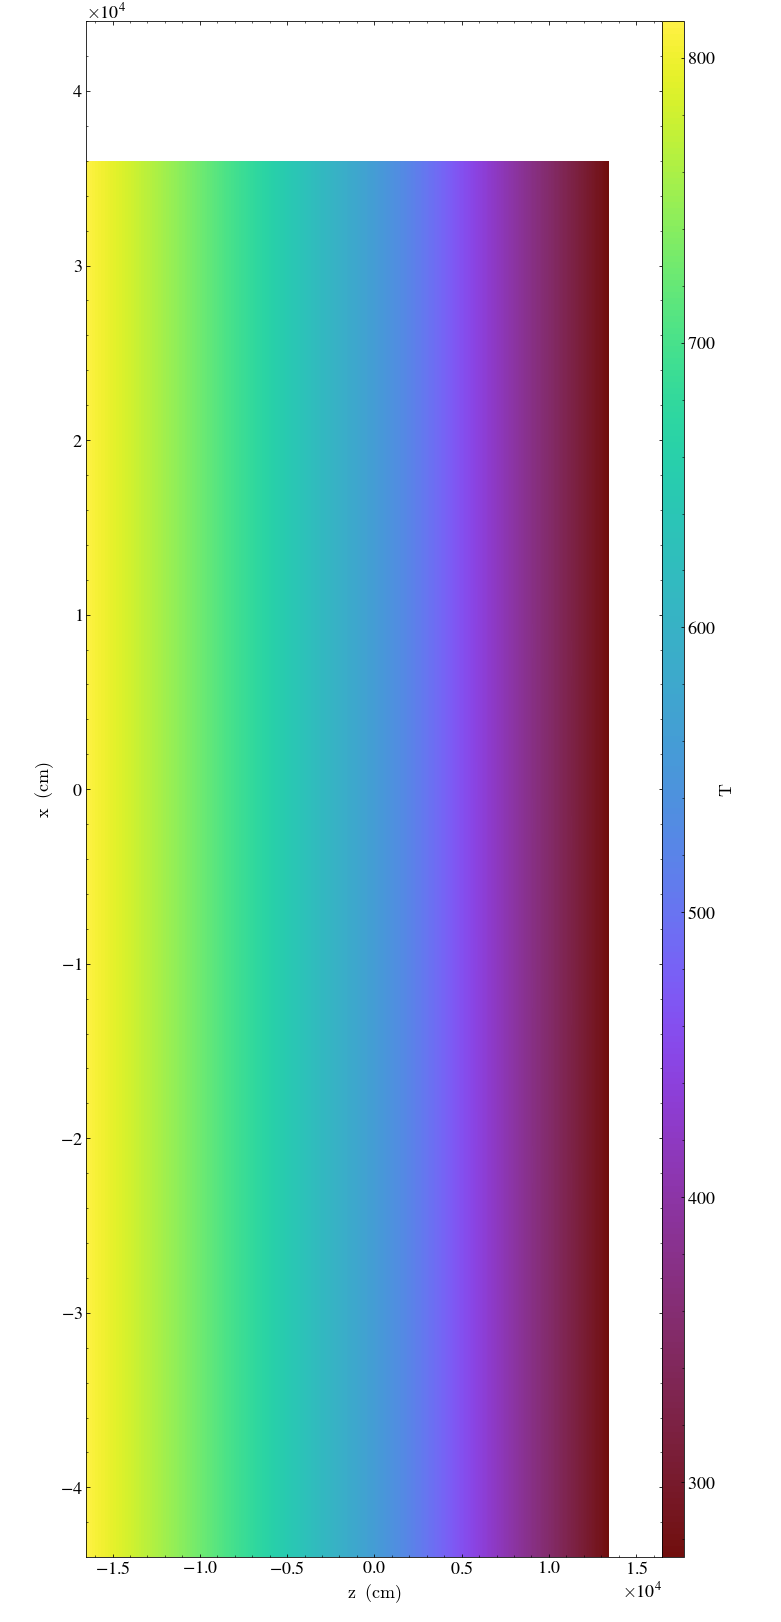

In [34]:
slc = yt.SlicePlot(ds_high_order,'y',('all','T'))
slc.set_log('T',False)
slc.show()

We see the *yt* warning message: `High order elements not yet supported, dropping to 1st order."`. So until the shape functions for the higher order elements are added to *yt*, we can still plot ASPECT output files that contain the higher order elements. 

## 2. Loading ASPECT data with a yt-native front end

An initial draft front end for ASPECT data is available on the `aspect` branch of the yt fork at: https://github.com/chrishavlin/yt. Until a PR is submitted and the `aspect` branch makes its way into the main yt repository, you can clone the fork, checkout the `aspect` branch and install from source with `pip install .`

Once installed, we can load the data using the usual yt method:

In [37]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','./'),'output_yt_vtu','solution')
pFile=os.path.join(DataDir,'solution-00000.pvtu')

In [38]:
ds = yt.load(pFile)

yt : [INFO     ] 2020-11-17 15:49:14,403 detected cell type is hexahedron.
yt : [INFO     ] 2020-11-17 15:49:14,466 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-17 15:49:14,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-11-17 15:49:14,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-17 15:49:14,467 Parameters: domain_right_edge         = [100000. 100000. 100000.]
yt : [INFO     ] 2020-11-17 15:49:14,467 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2020-11-17 15:49:14,491 detected cell type is hexahedron.


yt : [INFO     ] 2020-11-17 15:50:28,808 xlim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-17 15:50:28,808 ylim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-17 15:50:28,809 xlim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-17 15:50:28,809 ylim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-17 15:50:28,810 Making a fixed resolution buffer of (('all', 'T')) 800 by 800



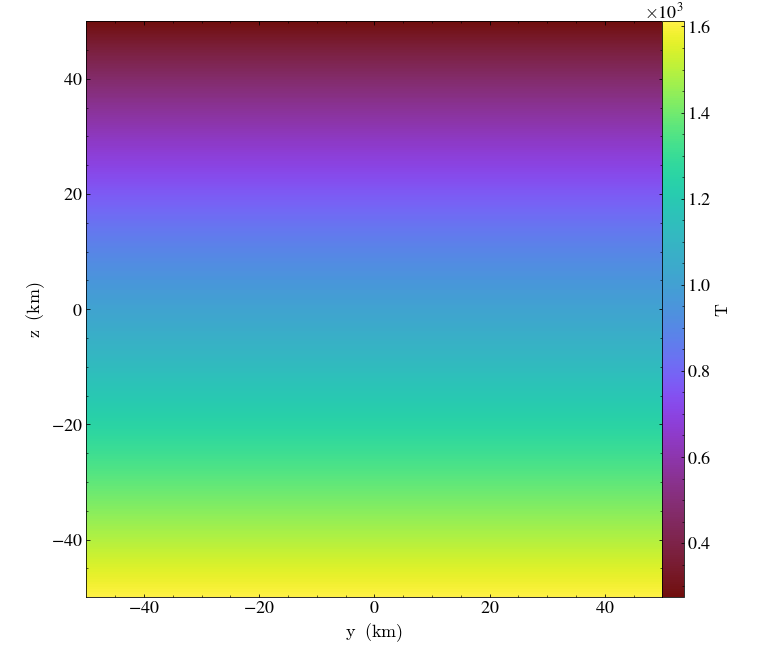

In [40]:
slc = yt.SlicePlot(ds,'x',('all','T'))
slc.show()

Let's load up a more complex geometry using data from Rajaonarison et al: 

["Edge-Driven Convection and Mantle Wind Models Beneath Madagascar", DOI 10.17605/OSF.IO/TEJM4, Authors: Tahiry Rajaonarison, Sarah Stamps, Stewart Fishwick, Sascha Brune, Anne Glerum, Jiashun Hu](https://osf.io/tejm4/)


In [41]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','../'),'edc_driven_convection_madagascar',
                     'edc_driven_convection_madagascar','solution')

pFile=os.path.join(DataDir,'solution-00005.pvtu')
if os.path.isfile(pFile) is False:
    print("data file not found")

In [42]:
ds = yt.load(pFile)

yt : [INFO     ] 2020-11-17 15:55:00,102 detected cell type is hexahedron.
yt : [INFO     ] 2020-11-17 15:55:01,323 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-17 15:55:01,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-11-17 15:55:01,323 Parameters: domain_left_edge          = [ 2976911.55685427  2976911.55685427 -2974571.8218114 ]
yt : [INFO     ] 2020-11-17 15:55:01,324 Parameters: domain_right_edge         = [5139637.19535828 5139637.19535828 -818078.5541581 ]
yt : [INFO     ] 2020-11-17 15:55:01,324 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2020-11-17 15:55:01,383 detected cell type is hexahedron.


yt : [INFO     ] 2020-11-17 15:55:05,462 xlim = 2976911.556854 5139637.195358
yt : [INFO     ] 2020-11-17 15:55:05,463 ylim = -2974571.821811 -818078.554158
yt : [INFO     ] 2020-11-17 15:55:05,463 xlim = 2976911.556854 5139637.195358
yt : [INFO     ] 2020-11-17 15:55:05,464 ylim = -2974571.821811 -818078.554158
yt : [INFO     ] 2020-11-17 15:55:05,464 Making a fixed resolution buffer of (('all', 'T')) 800 by 800



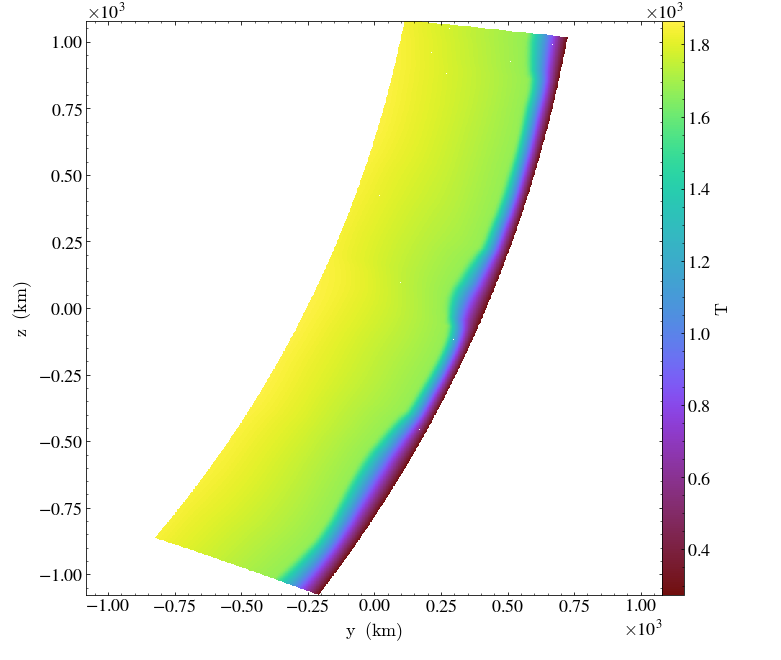

In [43]:
slc = yt.SlicePlot(ds,'x',('all','T'))
slc.show()

This draft frontend uses meshio behind the scenes, so we still need meshio installed in addition to *yt*. Additionally, if you're trying to plot higher order ASPECT output, you'll need the meshio fork as described in the above section on manually plotting higher order elements (as before, only the first order nodes will be used by *yt* at present). 